## Prediction of extreme snowmelt from SHMI data

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from random import randint, uniform

from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from sklearn.linear_model import LogisticRegression
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier

from lightgbm import LGBMRegressor



In [2]:
# setup for search grid
from scipy.stats import loguniform


class loguniform_int:
    """Integer valued version of the log-uniform distribution"""

    def __init__(self, a, b):
        self._distribution = loguniform(a, b)

    def rvs(self, *args, **kwargs):
        """Random variable sample"""
        return self._distribution.rvs(*args, **kwargs).astype(int)


### Data cleaning and exploration

In [3]:
# import files

snow_df = pd.read_csv('../snow.csv', low_memory=False)
flow_df = pd.read_csv('../flow.csv', low_memory=False)
snow_sites = pd.read_csv('../snow_sites.csv', low_memory=False)
flow_sites = pd.read_csv('../flow_sites.csv', low_memory=False)
site_pairs = pd.read_csv('../site_pairs_clean.csv', low_memory=False)


In [4]:
# Some data exploration
snow_df = snow_df[snow_df['snow_depth'].notna()]
snow_df = snow_df[snow_df['snow_depth'] != 'Snödjup']
snow_df.isnull().sum()
snow_df['snow_depth'] = snow_df['snow_depth'].astype(float)
snow_df.date = pd.to_datetime(snow_df.date)
snow_df['year'] = snow_df.date.dt.year
snow_df.head()


,date,time,snow_depth,quality,site_id,id,name,latitude,longitude,year
0,1945-01-02,07:00:00,0.67,G,173010,173010,Aapua,66.8656,23.4951,1945
1,1945-01-03,07:00:00,0.67,G,173010,173010,Aapua,66.8656,23.4951,1945
2,1945-01-04,07:00:00,0.66,G,173010,173010,Aapua,66.8656,23.4951,1945
3,1945-01-05,07:00:00,0.65,G,173010,173010,Aapua,66.8656,23.4951,1945
4,1945-01-06,07:00:00,0.65,G,173010,173010,Aapua,66.8656,23.4951,1945


In [8]:
snow_df.shape

(6365690, 10)

In [5]:
flow_df = flow_df.drop(['Unnamed: 0'], axis=1)
flow_df.columns = ['date', 'flow', 'quality', 'site_id', 'id', 'name', 'latitude', 'longitude']
flow_df = flow_df[flow_df['flow'].notna()]
flow_df.date = pd.to_datetime(flow_df.date)
flow_df.head()


,date,flow,quality,site_id,id,name,latitude,longitude
0,1984-08-17,106.7242,G,2357,2357,ABISKO,68.3559,18.8208
1,1984-08-18,103.7052,G,2357,2357,ABISKO,68.3559,18.8208
2,1984-08-19,99.4413,G,2357,2357,ABISKO,68.3559,18.8208
3,1984-08-20,93.1354,G,2357,2357,ABISKO,68.3559,18.8208
4,1984-08-21,93.7860,G,2357,2357,ABISKO,68.3559,18.8208


In [10]:
flow_df.shape

(7377920, 8)

In [6]:
# convert snow depth to binary variable (1 if depth is more than 0.05m shallower than two days before)
snow_df1 = snow_df[snow_df['site_id'] == 173010]
snow_df1 = snow_df.sort_values(by=['site_id', 'date'])
snow_df['depth_diff'] = snow_df.groupby(['site_id']).snow_depth.diff(periods=2)
snow_df['binary'] = (snow_df['depth_diff'] < -0.05).astype(int)
snow_df.head()


,date,time,snow_depth,quality,site_id,id,name,latitude,longitude,year,depth_diff,binary
0,1945-01-02,07:00:00,0.67,G,173010,173010,Aapua,66.8656,23.4951,1945,NaN,0
1,1945-01-03,07:00:00,0.67,G,173010,173010,Aapua,66.8656,23.4951,1945,NaN,0
2,1945-01-04,07:00:00,0.66,G,173010,173010,Aapua,66.8656,23.4951,1945,-0.01,0
3,1945-01-05,07:00:00,0.65,G,173010,173010,Aapua,66.8656,23.4951,1945,-0.02,0
4,1945-01-06,07:00:00,0.65,G,173010,173010,Aapua,66.8656,23.4951,1945,-0.01,0


In [7]:
# remove rows where previous value is not two days away
snow_df['date_diff'] = snow_df.groupby(['site_id']).date.diff(periods=2)
snow_df = snow_df[snow_df['date_diff'] == pd.Timedelta(days=2)]

In [8]:
# some cleaning - remove null values and duplicate rows
snow_df = snow_df[snow_df['binary'].notna()]
snow_df.binary.value_counts()

0    5476226
1     298996
Name: binary, dtype: int64

In [14]:
print('Percentage of extreme snowmelt events: ', round(snow_df.binary.sum() / snow_df.binary.count() * 100, 2), '%')

Percentage of extreme snowmelt events:  5.18 %


In [15]:
snow_df[snow_df['binary'] == 1]

,date,time,snow_depth,quality,site_id,id,name,latitude,longitude,year,depth_diff,binary,date_diff
81,1945-03-24,07:00:00,0.78,G,173010,173010,Aapua,66.8656,23.4951,1945,-0.06,1,2 days
85,1945-03-28,07:00:00,0.68,G,173010,173010,Aapua,66.8656,23.4951,1945,-0.06,1,2 days
86,1945-03-29,07:00:00,0.66,G,173010,173010,Aapua,66.8656,23.4951,1945,-0.06,1,2 days
107,1945-04-19,07:00:00,0.50,G,173010,173010,Aapua,66.8656,23.4951,1945,-0.05,1,2 days
115,1945-04-27,07:00:00,0.31,G,173010,173010,Aapua,66.8656,23.4951,1945,-0.09,1,2 days
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6366665,2011-04-12,06:00:00,0.40,G,171700,171700,Övre Svartlå D,66.0213,21.1727,2011,-0.08,1,2 days
6366667,2011-04-14,06:00:00,0.35,G,171700,171700,Övre Svartlå D,66.0213,21.1727,2011,-0.05,1,2 days
6366668,2011-04-15,06:00:00,0.30,G,171700,171700,Övre Svartlå D,66.0213,21.1727,2011,-0.10,1,2 days
6366670,2011-04-17,06:00:00,0.00,G,171700,171700,Övre Svartlå D,66.0213,21.1727,2011,-0.30,1,2 days


In [9]:
site_pairs.columns = ['Bas0_ID', 'BASINNAME', 'Mean_Elev', 'Shape_Leng', 'Shape_Area',
                      'flow_site_id', 'snow_site_id', 'snow_name', 'snow_latitude',
                      'snow_longitude', 'snow_year_count', 'snow_obs_per_ye', 'distance']
site_pairs.head()


,Bas0_ID,BASINNAME,Mean_Elev,Shape_Leng,Shape_Area,flow_site_id,snow_site_id,snow_name,snow_latitude,snow_longitude,snow_year_count,snow_obs_per_ye,distance
0,W3B2002700,NaN,440.424335,55600,64270000,4,181970,Esrange,67.8907,21.0832,33,228.333333,79502.045451
1,W3B2002700,NaN,440.424335,55600,64270000,4,180940,Kiruna flygplats,67.8270,20.3387,36,141.638889,102500.768170
2,W3B2002700,NaN,440.424335,55600,64270000,4,180960,Kiruna,67.8514,20.2496,111,111.351351,107047.616796
3,W3B2002700,NaN,440.424335,55600,64270000,4,189760,Torneträsk,68.2201,19.7123,15,239.733333,147286.250971
4,W3B2002700,NaN,440.424335,55600,64270000,4,188800,Abisko,68.3538,18.8166,69,132.637681,186365.745096


In [10]:
# merge snow and flow data
all_data = pd.merge(snow_df[['date', 'site_id', 'snow_depth', 'depth_diff', 'binary']], site_pairs[['flow_site_id', 'snow_site_id', 'distance']], left_on='site_id', 
	right_on='snow_site_id', how='left')
all_data = all_data[all_data['distance'].notna()]
all_data.drop(['site_id'], axis=1, inplace=True)
all_data = pd.merge(all_data, flow_df[['date', 'site_id', 'flow']], left_on=['date', 'flow_site_id'], right_on=['date', 'site_id'], how='inner')
all_data.drop(['site_id'], axis=1, inplace=True)
all_data.head()


,date,snow_depth,depth_diff,binary,flow_site_id,snow_site_id,distance,flow
0,1945-05-23,0.0,0.0,0,51.0,157010.0,35296.19718,182.0
1,1945-05-24,0.0,0.0,0,51.0,157010.0,35296.19718,176.0
2,1945-05-25,0.0,0.0,0,51.0,157010.0,35296.19718,164.0
3,1945-05-26,0.0,0.0,0,51.0,157010.0,35296.19718,152.0
4,1945-05-27,0.0,0.0,0,51.0,157010.0,35296.19718,143.0


In [18]:
all_data.shape

(1556673, 8)

In [19]:
all_data.binary.value_counts()

0    1468371
1      88302
Name: binary, dtype: int64

In [20]:
print('Percentage of extreme snowmelt events: ', round(
    all_data.binary.sum() / all_data.binary.count() * 100, 2), '%')


Percentage of extreme snowmelt events:  5.67 %


In [11]:
# check which sites have more than 10 years of overlapping data
freq_df = all_data.groupby(['flow_site_id', 'snow_site_id'])['date'].agg([('year_count', lambda x: x.dt.year.max() - x.dt.year.min()),
                                                  ('obs_per_year', lambda x: x.count() / (x.dt.year.max() - x.dt.year.min()))])
freq_df = freq_df.reset_index()
freq_df = freq_df[(freq_df['year_count'] >= 10) & (freq_df['obs_per_year'] >= 100)]
freq_df

<ipython-input-11-514b76abe780>:3: RuntimeWarning: divide by zero encountered in long_scalars
  ('obs_per_year', lambda x: x.count() / (x.dt.year.max() - x.dt.year.min()))])


,flow_site_id,snow_site_id,year_count,obs_per_year
0,4.0,180940.0,26,287.153846
2,4.0,181970.0,33,248.333333
3,4.0,188800.0,54,201.759259
4,4.0,188820.0,51,330.960784
6,4.0,189760.0,24,243.958333
...,...,...,...,...
308,2506.0,148200.0,15,344.866667
309,10006.0,191900.0,24,302.208333
310,10006.0,191940.0,14,371.714286
311,10006.0,192830.0,49,287.346939


In [12]:
# only keep sites with more than 10 years of overlapping data
all_data_clean = all_data[(all_data['flow_site_id'].isin(freq_df['flow_site_id'])) & (all_data['snow_site_id'].isin(freq_df['snow_site_id']))]
all_data_clean.binary.value_counts()

0    1420814
1      85438
Name: binary, dtype: int64

In [23]:
print('Percentage of extreme snowmelt events: ', round(
    all_data_clean.binary.sum() / all_data_clean.binary.count() * 100, 2), '%')


Percentage of extreme snowmelt events:  5.67 %


In [13]:
all_data_clean.head()

,date,snow_depth,depth_diff,binary,flow_site_id,snow_site_id,distance,flow
0,1945-05-23,0.0,0.0,0,51.0,157010.0,35296.19718,182.0
1,1945-05-24,0.0,0.0,0,51.0,157010.0,35296.19718,176.0
2,1945-05-25,0.0,0.0,0,51.0,157010.0,35296.19718,164.0
3,1945-05-26,0.0,0.0,0,51.0,157010.0,35296.19718,152.0
4,1945-05-27,0.0,0.0,0,51.0,157010.0,35296.19718,143.0


In [14]:
all_data_clean.isnull().sum()

date            0
snow_depth      0
depth_diff      0
binary          0
flow_site_id    0
snow_site_id    0
distance        0
flow            0
dtype: int64

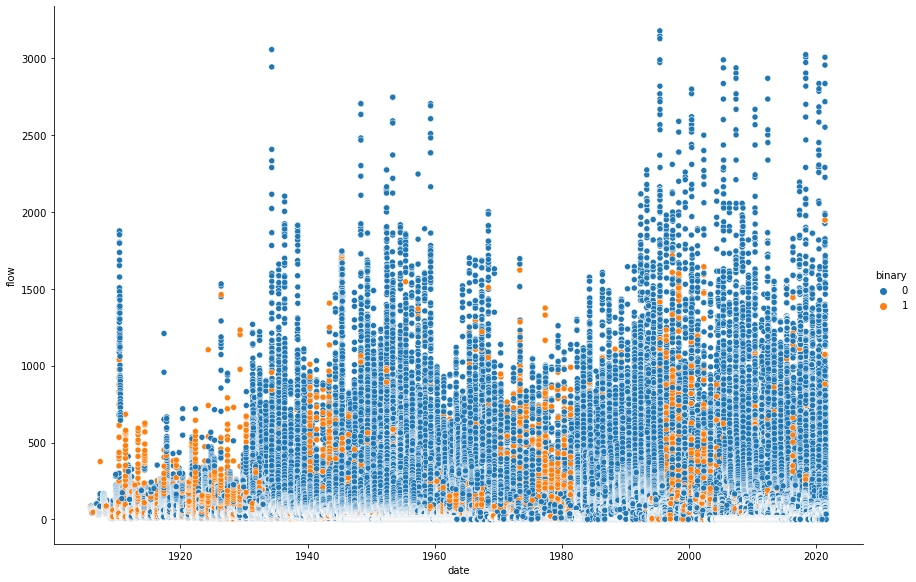

In [26]:
sns.relplot(x="date", y="flow", data=all_data_clean,
            hue="binary", kind="scatter", height=8, aspect=1.5)


<ipython-input-16-4cf8c10f4902>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_data_clean['year'] = all_data_clean.date.dt.year


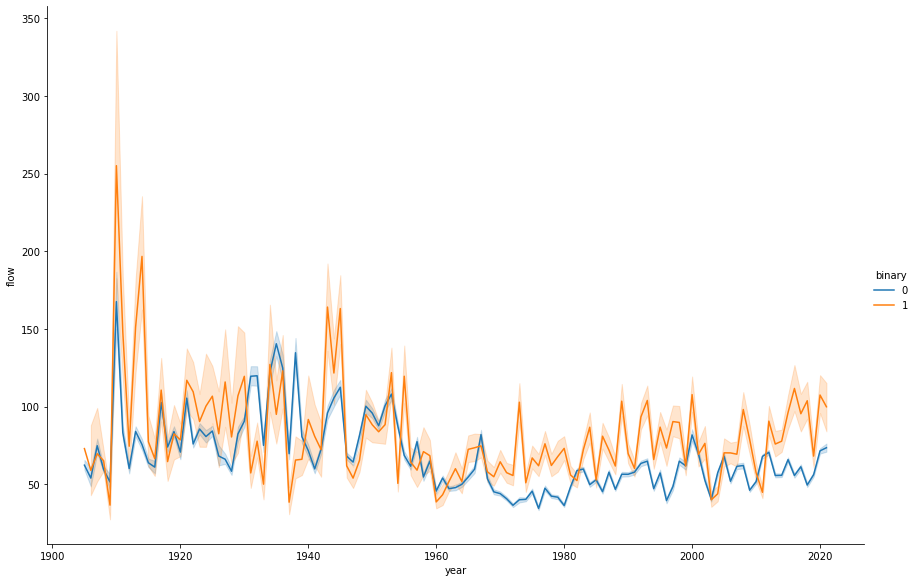

In [16]:
all_data_clean['year'] = all_data_clean.date.dt.year
sns.relplot(x="year", y="flow", hue="binary", data=all_data_clean, kind="line", height=8, aspect=1.5)


<ipython-input-17-ccc1aef8568a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_data_clean['month'] = all_data_clean.date.dt.month


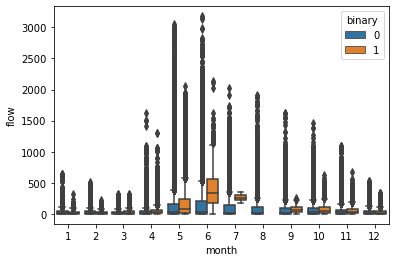

In [17]:
all_data_clean['month'] = all_data_clean.date.dt.month
sns.boxplot(x="month", y="flow", hue="binary", data=all_data_clean)


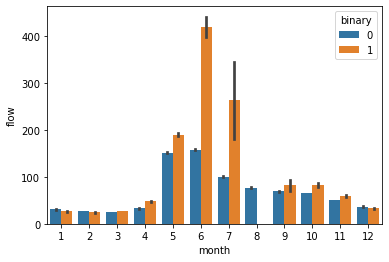

In [29]:
sns.barplot(x="month", y="flow", hue="binary", data=all_data_clean)

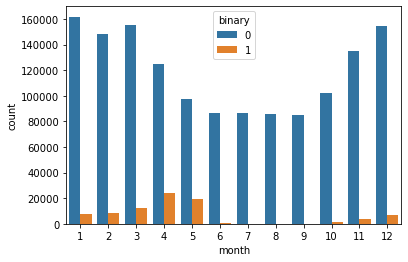

In [30]:
sns.countplot(x="month", hue="binary", data=all_data_clean)


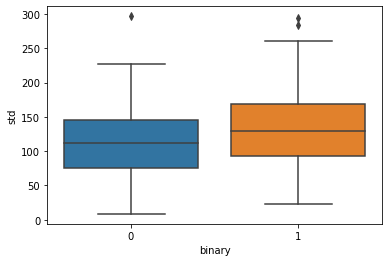

In [31]:

year_mean = all_data_clean.groupby(['year', 'binary'])['flow'].agg(['mean', 'std']).reset_index()
sns.boxplot(x="binary", y="std", data=year_mean)

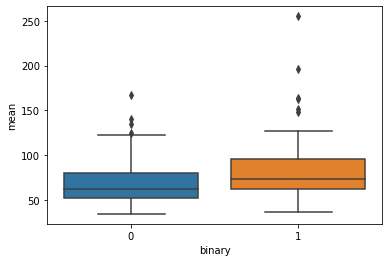

In [32]:
sns.boxplot(x="binary", y="mean", data=year_mean)


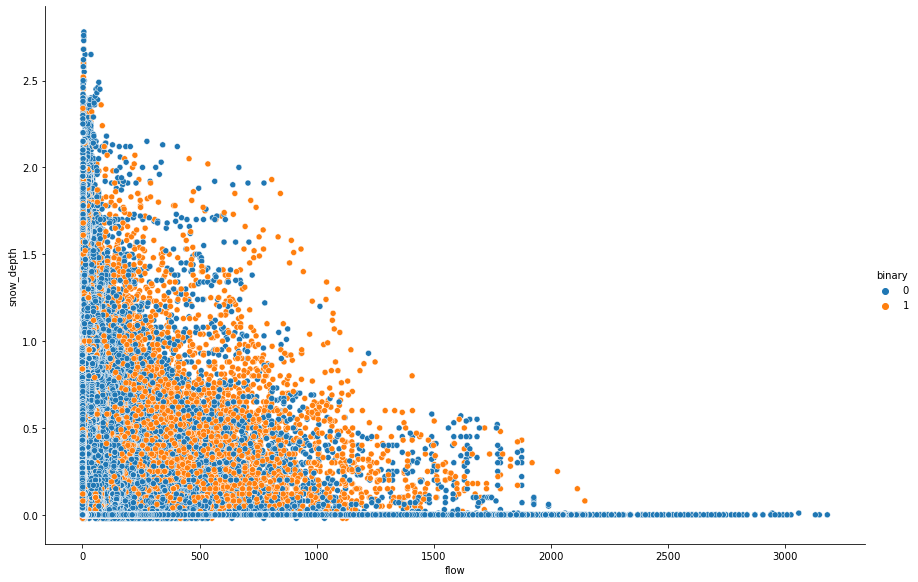

In [33]:
sns.relplot(x="flow", y="snow_depth", hue="binary", data=all_data_clean, kind="scatter", height=8, aspect=1.5)

In [18]:
# add average and max flow for previous month
all_data_clean['year'] = all_data_clean.date.dt.year
all_data_clean['month'] = all_data_clean.date.dt.month
all_data_clean['flow_prev_month'] = all_data_clean.groupby(['year', 'month'])['flow'].transform('mean')
all_data_clean['flow_prev_month_max'] = all_data_clean.groupby(['year', 'month'])['flow'].transform('max')


<ipython-input-18-0aab209bd83f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_data_clean['flow_prev_month'] = all_data_clean.groupby(['year', 'month'])['flow'].transform('mean')
<ipython-input-18-0aab209bd83f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_data_clean['flow_prev_month_max'] = all_data_clean.groupby(['year', 'month'])['flow'].transform('max')


In [34]:
# TODO: some plots and stats: how unbalanced is the snow depth data?

### Building the model

#### Snow depth and flow only

In [19]:
# split training, test, validation data
scores = {}
n_splits = 5

all_data_clean = all_data_clean.sort_values(by=['date'], ascending=True)
X = all_data_clean[['flow', 'flow_prev_month', 'flow_prev_month_max']]
y = all_data_clean['binary']
tscv = TimeSeriesSplit(n_splits=n_splits)


In [20]:
# build scorer function
def auc_pr_score(y_true, y_pred):
	precision, recall, _ = precision_recall_curve(y_true, y_pred)
	return auc(recall, precision)


auc_pr = make_scorer(auc_pr_score, greater_is_better=True)


In [21]:
# baseline model: naive predictor (always zero)
y_pred = np.zeros(y.shape)
auc_score = auc_pr_score(y, y_pred)
scores['baseline'] = auc_score


In [22]:
# a test with logistic regression

tmp_scores = []
for train_index, test_index in tscv.split(X):

    data_train = X.loc[X.index.intersection(train_index), :]
    target_train = y.loc[y.index.intersection(train_index)]

    data_test = X.loc[X.index.intersection(test_index), :]
    target_test = y.loc[y.index.intersection(test_index)]

    clf = LogisticRegression(class_weight={0: 1, 1: 10})
    clf.fit(data_train, target_train)

    preds = clf.predict(data_test)
    y_pred = pd.Series(np.round(preds), index=data_test.index, name='predicted')
    gridsearchpreds = pd.concat([target_test, y_pred], axis=1)
    print(gridsearchpreds.value_counts())

    auc_score = auc_pr_score(target_test, preds)
    print(auc_score)

    tmp_scores.append(auc_score)

# this is the average accuracy over all folds
average_score = np.mean(tmp_scores)
scores['logistic regression'] = average_score


binary  predicted
0       0            222484
1       0             13646
0       1              8528
1       1               971
dtype: int64
0.11210305786372257
binary  predicted
0       0            213111
        1             17583
1       0             12431
        1              1042
dtype: int64
0.09209902476403574
binary  predicted
0       0            229549
1       0             14711
0       1               896
1       1               176
dtype: int64
0.11798257048143763
binary  predicted
0       0            226315
1       0             13230
0       1              6535
1       1               710
dtype: int64
0.1012697594283057
binary  predicted
0       0            220236
1       0             13352
0       1              4336
1       1               462
dtype: int64
0.09287222665412544


In [24]:
# LightGBM-like ensemble model - parameters tuned for this dataset

index_output = tscv.split(X)

clf = HistGradientBoostingClassifier(loss='binary_crossentropy', random_state=42, verbose=0).fit(X, y)
param_grid = {
    'learning_rate': (0.1, 1, 5, 7, 10, 20, 50, 100),
   	#'max_iter': (100, 200, 300, 500, 1000),
    'max_leaf_nodes': (1, 2, 3, 5, 10, 30)}

# consider using RandomizedSearchCV instead of GridSearchCV
# gs = GridSearchCV(clf, param_grid=param_grid, cv=index_output, scoring=auc_pr, n_jobs=-1, verbose=1)
# gs.fit(X, y)
# gs.best_params_

param_distributions = {
    'l2_regularization': loguniform(1e-6, 1e3),
    'learning_rate': loguniform(0.001, 10),
    'max_leaf_nodes': loguniform_int(2, 256),
    'min_samples_leaf': loguniform_int(1, 100),
    'max_bins': loguniform_int(2, 255),
}

model_random_search = RandomizedSearchCV(
    clf, param_distributions=param_distributions, n_iter=200, n_jobs=-1, scoring=auc_pr,
    cv=index_output, verbose=1,
)
model_random_search.fit(X, y)
l2_regularization = model_random_search.best_params_['l2_regularization']
learning_rate = model_random_search.best_params_['learning_rate']
max_leaf_nodes = model_random_search.best_params_['max_leaf_nodes']
min_samples_leaf = model_random_search.best_params_['min_samples_leaf']
max_bins = model_random_search.best_params_['max_bins']
model_random_search.best_params_


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done 160 tasks      | elapsed:  2.1min
/home/cecilia/.local/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
[Parallel(n_jobs=-1)]: Done 410 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 760 tasks      | elapsed:  9.2min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 12.6min finished


{'l2_regularization': 131.12520655871074,
 'learning_rate': 0.007537252491263959,
 'max_bins': 2,
 'max_leaf_nodes': 199,
 'min_samples_leaf': 1}

In [27]:
# LightGBM-like ensemble model - cross validation with new parameters

new_regressor = HistGradientBoostingClassifier(
    loss='binary_crossentropy', random_state=42, l2_regularization=131.12520655871074,
    learning_rate=learning_rate,
    max_bins=max_bins,
    max_leaf_nodes=max_leaf_nodes,
    min_samples_leaf=min_samples_leaf, 
	verbose=0)
index_output = tscv.split(X)

cv_results = cross_validate(
    new_regressor,
    X,
    y,
    cv=index_output,
    scoring=auc_pr,
)

mean_score = np.mean(cv_results['test_score'])
scores['histogram gradient boosting'] = mean_score


Binning 0.005 GB of training data: 0.133 s
Binning 0.001 GB of validation data: 0.005 s
Fitting gradient boosted rounds:
[1/100] 1 tree, 7 leaves, max depth = 3, train loss: 0.21704, val loss: 0.21705, in 0.128s
[2/100] 1 tree, 7 leaves, max depth = 3, train loss: 0.21702, val loss: 0.21703, in 0.091s
[3/100] 1 tree, 7 leaves, max depth = 3, train loss: 0.21700, val loss: 0.21701, in 0.112s
[4/100] 1 tree, 7 leaves, max depth = 3, train loss: 0.21698, val loss: 0.21699, in 0.129s
[5/100] 1 tree, 7 leaves, max depth = 3, train loss: 0.21697, val loss: 0.21698, in 0.150s
[6/100] 1 tree, 7 leaves, max depth = 3, train loss: 0.21695, val loss: 0.21696, in 0.157s
[7/100] 1 tree, 7 leaves, max depth = 3, train loss: 0.21693, val loss: 0.21694, in 0.142s
[8/100] 1 tree, 7 leaves, max depth = 3, train loss: 0.21691, val loss: 0.21693, in 0.116s
[9/100] 1 tree, 7 leaves, max depth = 3, train loss: 0.21690, val loss: 0.21691, in 0.107s
[10/100] 1 tree, 7 leaves, max depth = 3, train loss: 0.2168

In [29]:
# check model predictions
y_pred = new_regressor.fit(X,y).predict(X)
y_pred = pd.Series(np.round(y_pred), index=X.index, name='predicted')
np.unique(y_pred)

Binning 0.033 GB of training data: 0.105 s
Binning 0.004 GB of validation data: 0.005 s
Fitting gradient boosted rounds:
[1/100] 1 tree, 8 leaves, max depth = 3, train loss: 0.21780, val loss: 0.21780, in 0.261s
[2/100] 1 tree, 8 leaves, max depth = 3, train loss: 0.21775, val loss: 0.21775, in 0.265s
[3/100] 1 tree, 8 leaves, max depth = 3, train loss: 0.21770, val loss: 0.21770, in 0.315s
[4/100] 1 tree, 8 leaves, max depth = 3, train loss: 0.21765, val loss: 0.21766, in 0.285s
[5/100] 1 tree, 8 leaves, max depth = 3, train loss: 0.21760, val loss: 0.21761, in 0.286s
[6/100] 1 tree, 8 leaves, max depth = 3, train loss: 0.21755, val loss: 0.21756, in 0.377s
[7/100] 1 tree, 8 leaves, max depth = 3, train loss: 0.21750, val loss: 0.21752, in 0.321s
[8/100] 1 tree, 8 leaves, max depth = 3, train loss: 0.21746, val loss: 0.21747, in 0.329s
[9/100] 1 tree, 8 leaves, max depth = 3, train loss: 0.21741, val loss: 0.21742, in 0.301s
[10/100] 1 tree, 8 leaves, max depth = 3, train loss: 0.2173

array([0])

In [31]:
# look at confusion matrix
gridsearchpreds = pd.concat([y, y_pred], axis=1)
gridsearchpreds.value_counts()


binary  predicted
0       0            1420814
1       0              85438
dtype: int64

In [32]:
# Random forest model

index_output = tscv.split(X)

clf = RandomForestClassifier(random_state=42, verbose=0)

param_distributions = {
	'n_estimators': loguniform_int(2, 256),
	'criterion': ['gini', 'entropy'],
	'min_samples_split': loguniform_int(2, 256),
	'min_samples_leaf': loguniform_int(1, 100),
	'class_weight': [{0: 1, 1: 10}, {0: 1, 1: 5}, {0: 1, 1: 2}, {0: 1, 1: 1}],
}

model_random_search = RandomizedSearchCV(
    clf, param_distributions=param_distributions, n_iter=200, n_jobs=-1, scoring=auc_pr,
    cv=index_output, verbose=1,
)
model_random_search.fit(X, y)
n_estimators = model_random_search.best_params_['n_estimators']
criterion = model_random_search.best_params_['criterion']
min_samples_split = model_random_search.best_params_['min_samples_split']
min_samples_leaf = model_random_search.best_params_['min_samples_leaf']
class_weight = model_random_search.best_params_['class_weight']
model_random_search.best_params_


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done 160 tasks      | elapsed: 14.0min
/home/cecilia/.local/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
[Parallel(n_jobs=-1)]: Done 410 tasks      | elapsed: 33.2min
[Parallel(n_jobs=-1)]: Done 760 tasks      | elapsed: 63.7min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 83.4min finished


{'class_weight': {0: 1, 1: 1},
 'criterion': 'entropy',
 'min_samples_leaf': 93,
 'min_samples_split': 120,
 'n_estimators': 77}

In [34]:
# random forest - cross validation with new parameters

new_regressor = RandomForestClassifier(
    random_state=42,
   	n_jobs=-1, verbose=0,
	criterion=criterion,
	min_samples_leaf=min_samples_leaf,
	min_samples_split=min_samples_split,
	n_estimators=n_estimators
	)
index_output = tscv.split(X)

cv_results = cross_validate(
    new_regressor,
    X,
    y,
    cv=index_output,
    scoring=auc_pr,
)

mean_score = np.mean(cv_results['test_score'])
scores['random forest'] = mean_score


In [35]:
# check model predictions
y_pred = new_regressor.fit(X,y).predict(X)
y_pred = pd.Series(np.round(y_pred), index=X.index, name='predicted')
np.unique(y_pred)


array([0, 1])

In [36]:
# look at confusion matrix
gridsearchpreds = pd.concat([y, y_pred], axis=1)
gridsearchpreds.value_counts()


binary  predicted
0       0            1420639
1       0              85113
        1                325
0       1                175
dtype: int64

In [37]:
# all AUC-PR
for key, value in scores.items():
	print(key, value)

baseline 0.5283611241678019
logistic regression 0.1032653278383254
histogram gradient boosting 0.5283892735080186
random forest 0.5283892735080186


In [ ]:
# TODO:
# 0. when do I need to normalize? Yes: RNN, logistic regression No: random forest, gradient boosting
# 1. try RNN (LSTM) with features already tried
# 2. mean and max flow of previous 30 days for all models
# 3. add distance as feature for all models
# 4. remove site pairs with distance > 100km
# 5. add month of year as feature for all models (it's categorical, try different combinations)
# 6. try forecasting snow depth diff instead of binary variable - use all feature combinations tried before

In [ ]:
# Features used to predict binary variable:
# 1. flow (poor, random or worse)
# 2. mean and max flow of the month (poor, random or worse)
# 3. flow + mean and max flow of the month (poor, random or worse)


In [ ]:
# Models tried so far:
# 1. Baseline (always predicts 0)
# 2. Logistic regression
# 3. Histogram gradient boosting
# 4. Random forest


In [ ]:
# Models to try:
# 1. Recursive Neural Network (LSTM)
# 2. Convolutional Neural Network?
# 3. Support Vector Machine?
# Various time lags?
# Binary target vs forecasting snow depth difference



In [ ]:
# Validation:
# 1. Forecast latest 2 or 5 years for every site
# 2. Keep 5 or 10 sites to check for extrapolation
# Metric: AUC-PR

In [ ]:
# Initially only snow depth vs flow, but potentially consider:
# 1. distance between sites (threshold or covariate)
# 2. temperature (nearest to flow site)
# 3. precipitation (nearest to flow site)
# 4. year (any temporal trend?)